## **Associating NDVI Values to Burrowing Owl Locations**

- generalist predators: rodents, moths, snakes, centipedes, songbirds, lizards, frogs, beetles, several others
- plant productivity (for which NDVI can be a proxy) has bottom up effects on animal populations (e.g. more NDVI, more seeds for rodents to eat)
- NDVI predicted small mammal prey abundance and nest initiation date in another generalist predatory bird, American kestrel (Smith et al. 2016)
- NDVI may predict movements in burrowing owl

**Burrowing Owl Location Dataset**: ~100,000 and counting burrowing owl locations collected via satellite transmitters by Dr. Courtney Conway (my advisor).  Each location is classified into a location class (lc) based on its location accuracy.  Each location class has an accuracy range:


- lc3 < 250 m
- 250 m < lc2 < 500 m
- 500 m < lc1 < 1500 m
- lc0 > 1500 m
- lcA,lcB - No accuracy estimate
- lcZ - Invalid Location


##### **Google Earth Engine Data**: MOD13Q1.006 Terra Vegetation Indices 
- 16-Day
- Global
- 250m


##### **Main Goal: create a process that assigns an NDVI value to each burrowing owl location**

##### Tasks Include:
1. subset data to only location classes 1,2,3 (only locations with a known accuracy)
2. buffer each point by 500 m
3. select imagery nearest in date to point
4. calculate mean NDVI value within each buffer
5. add NDVI values to original dataframe

In [1]:
import ee
from IPython.display import Image
import pandas as pd
import folium
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
import geopandas as gpd
%matplotlib inline

In [2]:
ee.Initialize()

In [3]:
#importing owl data
owldata = gpd.read_file("C://Users/loca0/Documents/Github/GIS_programming_F21/buow/Burrowing_Owl_Conway_Idaho/points.shp")
owldata

,timestamp,long,lat,outlier_al,altitude,best_level,calc_freq,error_radi,gdop,iq,...,ind_ident,study_name,utm_east,utm_north,utm_zone,study_tz,study_ts,date,time,geometry
0,2013-06-08 00:01:24,-117.66600,44.80800,F,0.0,0.0,0.000000e+00,0.0,0.0,None,...,120414,Burrowing Owl_Conway_Idaho,447333.991445,4.961838e+06,11N,Choibalsan Time,2013-06-08 08:01:24,2021-11-27,None,POINT (-117.66600 44.80800)
1,2013-06-08 00:28:06,-117.69600,44.78900,F,0.0,0.0,0.000000e+00,0.0,0.0,None,...,120414,Burrowing Owl_Conway_Idaho,444943.581706,4.959747e+06,11N,Choibalsan Time,2013-06-08 08:28:06,2021-11-27,None,POINT (-117.69600 44.78900)
2,2013-06-08 01:36:43,-117.67800,44.78600,F,0.0,0.0,0.000000e+00,0.0,0.0,None,...,120414,Burrowing Owl_Conway_Idaho,446364.676988,4.959402e+06,11N,Choibalsan Time,2013-06-08 09:36:43,2021-11-27,None,POINT (-117.67800 44.78600)
3,2013-06-08 02:08:25,-117.67600,44.79200,F,0.0,0.0,0.000000e+00,0.0,0.0,None,...,120414,Burrowing Owl_Conway_Idaho,446528.433529,4.960067e+06,11N,Choibalsan Time,2013-06-08 10:08:25,2021-11-27,None,POINT (-117.67600 44.79200)
4,2013-06-08 03:02:35,-117.69000,44.78400,F,0.0,0.0,0.000000e+00,0.0,0.0,None,...,120414,Burrowing Owl_Conway_Idaho,445413.493977,4.959188e+06,11N,Choibalsan Time,2013-06-08 11:02:35,2021-11-27,None,POINT (-117.69000 44.78400)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98378,2021-08-28 02:27:25,-109.72743,42.49571,F,2191.0,-135.0,4.016799e+08,512.0,1409.0,6,...,212974,Burrowing Owl_Conway_Idaho,604570.069508,4.705601e+06,12N,Choibalsan Time,2021-08-28 10:27:25,2021-11-27,None,POINT (-109.72743 42.49571)
98379,2021-08-28 02:29:21,-109.72657,42.49667,F,2193.0,-137.0,4.016799e+08,465.0,1268.0,6,...,212974,Burrowing Owl_Conway_Idaho,604639.137992,4.705709e+06,12N,Choibalsan Time,2021-08-28 10:29:21,2021-11-27,None,POINT (-109.72657 42.49667)
98380,2021-08-28 02:55:32,-109.72799,42.49765,F,2193.0,-127.0,4.016799e+08,380.0,1016.0,6,...,212974,Burrowing Owl_Conway_Idaho,604520.820994,4.705816e+06,12N,Choibalsan Time,2021-08-28 10:55:32,2021-11-27,None,POINT (-109.72799 42.49765)
98381,2021-08-28 03:24:38,-109.72745,42.49734,F,2193.0,-134.0,4.016799e+08,806.0,2253.0,6,...,212974,Burrowing Owl_Conway_Idaho,604565.709914,4.705782e+06,12N,Choibalsan Time,2021-08-28 11:24:38,2021-11-27,None,POINT (-109.72745 42.49734)


In [4]:
#Here I isolate lc's 1,2, and 3.  I'm sure there are better ways to subset data but this works!
selected = owldata['lc'] == '3'
owldata3 = owldata.loc[selected]

selected = owldata['lc'] == '2'
owldata2 = owldata.loc[selected]

selected = owldata['lc'] == '1'
owldata1 = owldata.loc[selected]

In [5]:
#appending together so back to 1 dataset
owldata123 = owldata3.append(owldata2).append(owldata1)
owldata123

,timestamp,long,lat,outlier_al,altitude,best_level,calc_freq,error_radi,gdop,iq,...,ind_ident,study_name,utm_east,utm_north,utm_zone,study_tz,study_ts,date,time,geometry
25,2013-06-09 09:10:49,-117.67800,44.79900,F,0.0,0.0,0.000000e+00,0.0,0.0,None,...,120414,Burrowing Owl_Conway_Idaho,446376.716980,4.960846e+06,11N,Choibalsan Time,2013-06-09 17:10:49,2021-11-27,None,POINT (-117.67800 44.79900)
60,2013-06-11 23:19:24,-117.66500,44.79400,F,0.0,0.0,0.000000e+00,0.0,0.0,None,...,120414,Burrowing Owl_Conway_Idaho,447400.350138,4.960282e+06,11N,Choibalsan Time,2013-06-12 07:19:24,2021-11-27,None,POINT (-117.66500 44.79400)
82,2013-06-14 03:31:36,-117.68300,44.79600,F,0.0,0.0,0.000000e+00,0.0,0.0,None,...,120414,Burrowing Owl_Conway_Idaho,445978.465678,4.960516e+06,11N,Choibalsan Time,2013-06-14 11:31:36,2021-11-27,None,POINT (-117.68300 44.79600)
119,2013-06-16 03:09:12,-117.68400,44.79600,F,0.0,0.0,0.000000e+00,0.0,0.0,None,...,120414,Burrowing Owl_Conway_Idaho,445899.371158,4.960517e+06,11N,Choibalsan Time,2013-06-16 11:09:12,2021-11-27,None,POINT (-117.68400 44.79600)
126,2013-06-16 12:44:50,-117.65900,44.79700,F,0.0,0.0,0.000000e+00,0.0,0.0,None,...,120414,Burrowing Owl_Conway_Idaho,447877.634365,4.960611e+06,11N,Choibalsan Time,2013-06-16 20:44:50,2021-11-27,None,POINT (-117.65900 44.79700)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98355,2021-08-26 02:26:59,-109.71178,42.49481,F,2192.0,-127.0,4.016799e+08,817.0,1411.0,56,...,212974,Burrowing Owl_Conway_Idaho,605857.604151,4.705521e+06,12N,Choibalsan Time,2021-08-26 10:26:59,2021-11-27,None,POINT (-109.71178 42.49481)
98359,2021-08-26 03:35:26,-109.74553,42.49532,F,2180.0,-130.0,4.016799e+08,632.0,275.0,46,...,212974,Burrowing Owl_Conway_Idaho,603083.369222,4.705536e+06,12N,Choibalsan Time,2021-08-26 11:35:26,2021-11-27,None,POINT (-109.74553 42.49532)
98361,2021-08-26 04:00:47,-109.72247,42.50640,F,2213.0,-123.0,4.016799e+08,523.0,233.0,46,...,212974,Burrowing Owl_Conway_Idaho,604959.765990,4.706794e+06,12N,Choibalsan Time,2021-08-26 12:00:47,2021-11-27,None,POINT (-109.72247 42.50640)
98367,2021-08-27 02:23:30,-109.69658,42.50391,F,2189.0,-125.0,4.016799e+08,793.0,268.0,46,...,212974,Burrowing Owl_Conway_Idaho,607091.128674,4.706550e+06,12N,Choibalsan Time,2021-08-27 10:23:30,2021-11-27,None,POINT (-109.69658 42.50391)


In [6]:
#Since I subset the data above by essentially making 3 subsets and then appending them together, the row indices got out of order.
#This might not matter or maybe it does?
#Either way it certainly makes things very confusing so the code below sorts the dataframe by the index number.
owldata123 = owldata123.sort_index(inplace=False)
owldata123

,timestamp,long,lat,outlier_al,altitude,best_level,calc_freq,error_radi,gdop,iq,...,ind_ident,study_name,utm_east,utm_north,utm_zone,study_tz,study_ts,date,time,geometry
0,2013-06-08 00:01:24,-117.66600,44.80800,F,0.0,0.0,0.000000e+00,0.0,0.0,None,...,120414,Burrowing Owl_Conway_Idaho,447333.991445,4.961838e+06,11N,Choibalsan Time,2013-06-08 08:01:24,2021-11-27,None,POINT (-117.66600 44.80800)
1,2013-06-08 00:28:06,-117.69600,44.78900,F,0.0,0.0,0.000000e+00,0.0,0.0,None,...,120414,Burrowing Owl_Conway_Idaho,444943.581706,4.959747e+06,11N,Choibalsan Time,2013-06-08 08:28:06,2021-11-27,None,POINT (-117.69600 44.78900)
4,2013-06-08 03:02:35,-117.69000,44.78400,F,0.0,0.0,0.000000e+00,0.0,0.0,None,...,120414,Burrowing Owl_Conway_Idaho,445413.493977,4.959188e+06,11N,Choibalsan Time,2013-06-08 11:02:35,2021-11-27,None,POINT (-117.69000 44.78400)
5,2013-06-08 03:16:09,-117.66100,44.78200,F,0.0,0.0,0.000000e+00,0.0,0.0,None,...,120414,Burrowing Owl_Conway_Idaho,447705.904852,4.958946e+06,11N,Choibalsan Time,2013-06-08 11:16:09,2021-11-27,None,POINT (-117.66100 44.78200)
6,2013-06-08 03:48:47,-117.70400,44.79800,F,0.0,0.0,0.000000e+00,0.0,0.0,None,...,120414,Burrowing Owl_Conway_Idaho,444319.404236,4.960752e+06,11N,Choibalsan Time,2013-06-08 11:48:47,2021-11-27,None,POINT (-117.70400 44.79800)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98370,2021-08-27 03:11:40,-109.72439,42.49506,F,2195.0,-120.0,4.016799e+08,441.0,171.0,46,...,212974,Burrowing Owl_Conway_Idaho,604820.962831,4.705533e+06,12N,Choibalsan Time,2021-08-27 11:11:40,2021-11-27,None,POINT (-109.72439 42.49506)
98372,2021-08-27 03:43:04,-109.72755,42.49610,F,2190.0,-119.0,4.016799e+08,397.0,200.0,56,...,212974,Burrowing Owl_Conway_Idaho,604559.558871,4.705644e+06,12N,Choibalsan Time,2021-08-27 11:43:04,2021-11-27,None,POINT (-109.72755 42.49610)
98374,2021-08-27 05:07:13,-109.72567,42.49435,F,2204.0,-124.0,4.016799e+08,904.0,244.0,48,...,212974,Burrowing Owl_Conway_Idaho,604716.964291,4.705452e+06,12N,Choibalsan Time,2021-08-27 13:07:13,2021-11-27,None,POINT (-109.72567 42.49435)
98375,2021-08-27 05:24:19,-109.73372,42.50637,F,2192.0,-125.0,4.016799e+08,361.0,440.0,56,...,212974,Burrowing Owl_Conway_Idaho,604035.520805,4.706777e+06,12N,Choibalsan Time,2021-08-27 13:24:19,2021-11-27,None,POINT (-109.73372 42.50637)


(14.44643, 51.057)

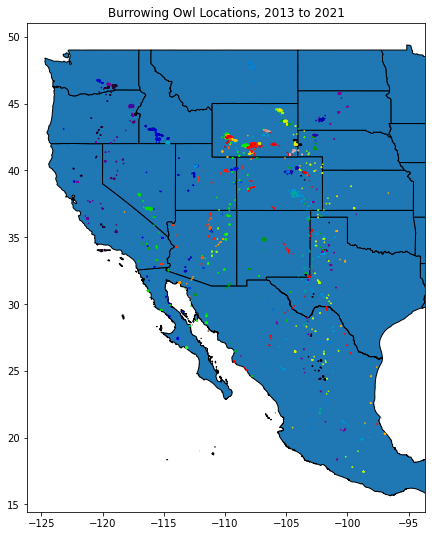

In [7]:
usa = gpd.read_file("C://Users/loca0/Documents/Github/GIS_programming_F21/weeks/wk04_vectorsII/assignment04/cb_2018_us_state_20m/cb_2018_us_state_20m_AL.shp")
mexico = gpd.read_file("C://Users/loca0/Documents/Github/GIS_programming_F21/weeks/wk04_vectorsII/assignment04/cb_2018_us_state_20m/mexico_AL.shp")

fig, ax = plt.subplots(figsize=(9,9))
owldata123.plot(column='ind_ident',markersize=0.4,cmap="nipy_spectral",zorder=2,legend=False,ax=ax)
usa.plot(zorder=1,edgecolor = 'black',ax=ax)
mexico.plot(edgecolor = 'black',ax=ax)
ax.set_title('Burrowing Owl Locations, 2013 to 2021')

owlextent = owldata123.geometry.total_bounds

xlim = ([owlextent[0]-3,  owlextent[2]+3])
ylim = ([owlextent[1]-3,  owlextent[3]+3])

ax.set_xlim(xlim)
ax.set_ylim(ylim)

In [ ]:
#####################################################################################################################################################################
#######Getting NDVI for 1 owl point within 500 m buffer

In [9]:
#Date is stored as a timestamp with both date and time.  Code below is to isolate date.
#This splits the timestamp into date and time and produces a dataframe
datedf = owldata123['timestamp'].str.split(' ', expand=True)
datedf.columns = ['date','time']
datedf

,date,time
0,2013-06-08,00:01:24
1,2013-06-08,00:28:06
4,2013-06-08,03:02:35
5,2013-06-08,03:16:09
6,2013-06-08,03:48:47
...,...,...
98370,2021-08-27,03:11:40
98372,2021-08-27,03:43:04
98374,2021-08-27,05:07:13
98375,2021-08-27,05:24:19


In [10]:
#converts the date into a geopandas series which makes it easier for me to pull out the one date I want
#must run this for for loop to work below
dateseries = datedf['date']

In [11]:
#this stores the date I want in the right format
owldate1 = dateseries[0]
owldate1

'2013-06-08'

In [12]:
#Isolating first point in dataframe
owlpointG = owldata123.loc[0]

In [13]:
# converting gpd point to a GEE type point
owlyG = owlpointG.geometry.y
owlxG = owlpointG.geometry.x
owl_locationG = ee.Geometry.Point(owlxG, owlyG)

In [14]:
# createing 500 m buffer around point to have a polygon to extract NDVI
owl_bufferedG = owl_locationG.buffer(500)

In [15]:
# GEE dataset has one image every 16 days so the date range creates a date window where one image must exist
owlDate2 = ee.Date(pd.to_datetime(owldate1))
date_range = ee.DateRange(owlDate2.advance(-8, 'days'), owlDate2.advance(8, 'days'))

In [16]:
#extracts the image within the date range of the point
NDVIimage = ee.ImageCollection("MODIS/006/MOD13Q1").filterDate(date_range).select('NDVI').first()

In [17]:
#gets the mean NDVI value within the 500 m buffer of the point and stores it in a dictionary with a whole bunch of other stuff
#with this data type I couldn't access the NDVI value
meanDict = NDVIimage.reduceRegion(ee.Reducer.mean(), owl_bufferedG)

In [18]:
#Here I pull out the NDVI value and store it in a simpler dictionary
NDVIvalue = meanDict.getInfo()

In [19]:
#finally I take out just the number I want, the NDVI value in a float data type
NDVIvalue['NDVI']

1979.5290760869566

In [20]:
##############################################################################################################################################################
######A loop to get all NDVI values and then add the NDVI column to original dataset

In [26]:
#delete or comment this cell when done!!!!! I reduce the dataset because loop takes so long to run. Do not run this cell to process entire dataset.
owldata123 = owldata123[0:50]

In [27]:
#Here I make numpy array which contains all the indices of the original dataset which will facilitate a for loop
owlindices = np.array(owldata123.index)
owlindices

array([  0,   1,   4,   5,   6,   7,   8,  15,  16,  20,  21,  22,  25,
        26,  27,  31,  32,  33,  36,  37,  41,  43,  46,  47,  50,  52,
        54,  58,  60,  63,  66,  68,  71,  74,  76,  80,  81,  82,  84,
        85,  87,  88,  91,  92,  97,  98,  99, 100, 108, 109], dtype=int64)

In [28]:
# This creates an empty list so I have somewhere to accumulate the NDVI values
NDVIlist = []

In [29]:
for i in owlindices:
    owlDateLoop = dateseries[i]
    #Isolating the ith point in a dataframe
    owlpoint = owldata123.loc[i]
    #converting the ith gpd point to a GEE type point
    owly = owlpoint.geometry.y
    owlx = owlpoint.geometry.x
    owl_location = ee.Geometry.Point(owlx, owly)
    #creating 500 m buffer around the ith point to have a polygon to extract NDVI
    owl_buffered = owl_location.buffer(500)
    #GEE dataset has one image every 16 days so the date range creates a date window where one image must exist
    owlDateLoop2 = ee.Date(pd.to_datetime(owlDateLoop))
    date_range = ee.DateRange(owlDateLoop2.advance(-8, 'days'), owlDateLoop2.advance(8, 'days'))
    #extracts the image within the date range of the point
    NDVIimage = ee.ImageCollection("MODIS/006/MOD13Q1").filterDate(date_range).select('NDVI').first()
    #gets the mean NDVI value within the 500 m buffer of the point and stores it in a dictionary
    meanDict = NDVIimage.reduceRegion(ee.Reducer.mean(), owl_buffered)
    #pull out the NDVI value and store it in a simpler dictionary
    NDVIvalue = meanDict.getInfo()
    #here I store the NDVI values in a list
    NDVIlist.append(NDVIvalue['NDVI'])

In [32]:
NDVIlist

[1979.5290760869566,
 1975.1718325176732,
 1929.9584577789844,
 1925.1113525258017,
 2002.7809446254068,
 2007.0516304347823,
 1791.1097826086955,
 2004.4306648575314,
 1922.1420423682778,
 1998.711648112952,
 2005.6753599565338,
 2008.2578718783934,
 1849.6211298207493,
 1889.9138352813266,
 1861.0162954915802,
 2392.743485342019,
 1984.2559717698155,
 1929.693999456964,
 2000.3308863512775,
 2059.12055389628,
 1790.1013311600102,
 1889.2976125881712,
 1951.3752375780612,
 1885.7525801195006,
 1796.0127613358675,
 1834.8491180461338,
 2123.2156436719174,
 2008.8768687143247,
 1868.7655528389023,
 1802.775183274505,
 2925.359489546566,
 2008.358577633008,
 2044.6065796628595,
 2451.324735270161,
 1981.0013579576319,
 1922.3207495926126,
 1874.8633152173913,
 1924.3057896167434,
 1890.3665490089597,
 1847.1094811192606,
 1870.6811515480717,
 1883.951100244499,
 3090.2432065217395,
 1963.2469470827682,
 3408.626934564214,
 1971.3431212615556,
 1950.137734311328,
 1914.5753052917237,
 213

In [33]:
NDVIseries = pd.Series(NDVIlist, index=owlindices)
NDVIseries

0      1979.529076
1      1975.171833
4      1929.958458
5      1925.111353
6      2002.780945
7      2007.051630
8      1791.109783
15     2004.430665
16     1922.142042
20     1998.711648
21     2005.675360
22     2008.257872
25     1849.621130
26     1889.913835
27     1861.016295
31     2392.743485
32     1984.255972
33     1929.693999
36     2000.330886
37     2059.120554
41     1790.101331
43     1889.297613
46     1951.375238
47     1885.752580
50     1796.012761
52     1834.849118
54     2123.215644
58     2008.876869
60     1868.765553
63     1802.775183
66     2925.359490
68     2008.358578
71     2044.606580
74     2451.324735
76     1981.001358
80     1922.320750
81     1874.863315
82     1924.305790
84     1890.366549
85     1847.109481
87     1870.681152
88     1883.951100
91     3090.243207
92     1963.246947
97     3408.626935
98     1971.343121
99     1950.137734
100    1914.575305
108    2133.698262
109    2143.388542
dtype: float64

In [34]:
###creates pd dataframe with value and index number
NewDF = pd.DataFrame(NDVIseries, columns=['NDVI_AL'])
NewDF

,NDVI_AL
0,1979.529076
1,1975.171833
4,1929.958458
5,1925.111353
6,2002.780945
7,2007.051630
8,1791.109783
15,2004.430665
16,1922.142042
20,1998.711648


In [35]:
owldata123.assign(NDVI_AL=NewDF['NDVI_AL'])

,timestamp,long,lat,outlier_al,altitude,best_level,calc_freq,error_radi,gdop,iq,...,study_name,utm_east,utm_north,utm_zone,study_tz,study_ts,date,time,geometry,NDVI_AL
0,2013-06-08 00:01:24,-117.666,44.808,F,0.0,0.0,0.0,0.0,0.0,None,...,Burrowing Owl_Conway_Idaho,447333.991445,4.961838e+06,11N,Choibalsan Time,2013-06-08 08:01:24,2021-11-27,None,POINT (-117.66600 44.80800),1979.529076
1,2013-06-08 00:28:06,-117.696,44.789,F,0.0,0.0,0.0,0.0,0.0,None,...,Burrowing Owl_Conway_Idaho,444943.581706,4.959747e+06,11N,Choibalsan Time,2013-06-08 08:28:06,2021-11-27,None,POINT (-117.69600 44.78900),1975.171833
4,2013-06-08 03:02:35,-117.690,44.784,F,0.0,0.0,0.0,0.0,0.0,None,...,Burrowing Owl_Conway_Idaho,445413.493977,4.959188e+06,11N,Choibalsan Time,2013-06-08 11:02:35,2021-11-27,None,POINT (-117.69000 44.78400),1929.958458
5,2013-06-08 03:16:09,-117.661,44.782,F,0.0,0.0,0.0,0.0,0.0,None,...,Burrowing Owl_Conway_Idaho,447705.904852,4.958946e+06,11N,Choibalsan Time,2013-06-08 11:16:09,2021-11-27,None,POINT (-117.66100 44.78200),1925.111353
6,2013-06-08 03:48:47,-117.704,44.798,F,0.0,0.0,0.0,0.0,0.0,None,...,Burrowing Owl_Conway_Idaho,444319.404236,4.960752e+06,11N,Choibalsan Time,2013-06-08 11:48:47,2021-11-27,None,POINT (-117.70400 44.79800),2002.780945
7,2013-06-08 04:42:47,-117.697,44.793,F,0.0,0.0,0.0,0.0,0.0,None,...,Burrowing Owl_Conway_Idaho,444868.285960,4.960192e+06,11N,Choibalsan Time,2013-06-08 12:42:47,2021-11-27,None,POINT (-117.69700 44.79300),2007.051630
8,2013-06-08 04:47:13,-117.676,44.797,F,0.0,0.0,0.0,0.0,0.0,None,...,Burrowing Owl_Conway_Idaho,446533.050797,4.960622e+06,11N,Choibalsan Time,2013-06-08 12:47:13,2021-11-27,None,POINT (-117.67600 44.79700),1791.109783
15,2013-06-08 22:12:16,-117.628,44.804,F,0.0,0.0,0.0,0.0,0.0,None,...,Burrowing Owl_Conway_Idaho,450335.527727,4.961369e+06,11N,Choibalsan Time,2013-06-09 06:12:16,2021-11-27,None,POINT (-117.62800 44.80400),2004.430665
16,2013-06-08 23:51:35,-117.699,44.812,F,0.0,0.0,0.0,0.0,0.0,None,...,Burrowing Owl_Conway_Idaho,444728.233942,4.962304e+06,11N,Choibalsan Time,2013-06-09 07:51:35,2021-11-27,None,POINT (-117.69900 44.81200),1922.142042
20,2013-06-09 02:45:22,-117.696,44.803,F,0.0,0.0,0.0,0.0,0.0,None,...,Burrowing Owl_Conway_Idaho,444956.892946,4.961302e+06,11N,Choibalsan Time,2013-06-09 10:45:22,2021-11-27,None,POINT (-117.69600 44.80300),1998.711648
